In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

import zipfile

from sklearn.utils.class_weight import compute_class_weight

In [3]:
# Aplicando o augmentation que será definido em todas as imagens do treino e validação
import cv2
import random

def modify_hue(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hue_shift = random.uniform(-0.1, 0.1)
    image_hsv[:,:,0] += hue_shift
    image_hsv[:,:,0] = np.clip(image_hsv[:,:,0], 0, 1)
    image_rgb = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
    return image_rgb

train_datagen = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    preprocessing_function=modify_hue,
)

Found 24402 images belonging to 2 classes.
Found 8608 images belonging to 2 classes.


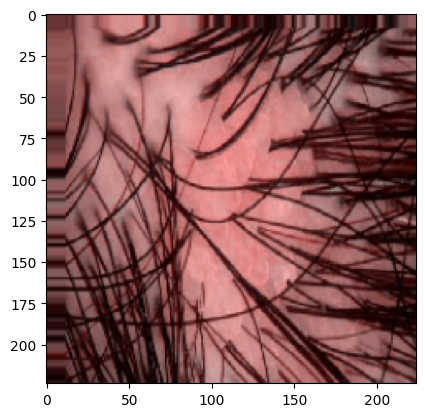

In [5]:
train_generator = train_datagen.flow_from_directory(
    '/content/drive/Shareddrives/IA901/dados melanoma/data/interim/treino',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    preprocessing_function=modify_hue
)

validation_generator = test_datagen.flow_from_directory(
         '/content/drive/Shareddrives/IA901/dados melanoma/data/interim/validacao',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
       )

# Visualiza as transformações de augmentation nas imagens
for i in range(1):
    image = train_generator[0][0][0].astype('uint8')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
    plt.show()

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Calculamos os pesos das classes para que seja penalisado no treino posteriormente
classes = np.unique(train_generator.classes)
class_counts = np.bincount(train_generator.classes)
total_samples = np.sum(class_counts)
class_weights = total_samples / (len(classes) * class_counts)

train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

{0: 0.5090749780948804, 1: 28.048275862068966}


In [8]:
image_size=(224, 224)

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(512, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=(224, 224, 3), num_classes=2)

In [11]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC()]
)
model_history = model.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator,
)

Epoch 1/10
763/763 [==============================] - 15961s 21s/step - loss: 0.1004 - auc: 0.9825 - val_loss: 0.0843 - val_auc: 0.9830
Epoch 2/10
763/763 [==============================] - 546s 716ms/step - loss: 0.0887 - auc: 0.9825 - val_loss: 0.0842 - val_auc: 0.9831
Epoch 3/10
763/763 [==============================] - 528s 692ms/step - loss: 0.0872 - auc: 0.9827 - val_loss: 0.0812 - val_auc: 0.9832
Epoch 4/10
763/763 [==============================] - 532s 697ms/step - loss: 0.0847 - auc: 0.9831 - val_loss: 0.0796 - val_auc: 0.9866
Epoch 5/10
763/763 [==============================] - 530s 694ms/step - loss: 0.0833 - auc: 0.9838 - val_loss: 0.0820 - val_auc: 0.9830
Epoch 6/10
763/763 [==============================] - 529s 693ms/step - loss: 0.0830 - auc: 0.9839 - val_loss: 0.0793 - val_auc: 0.9867
Epoch 7/10
763/763 [==============================] - 528s 693ms/step - loss: 0.0819 - auc: 0.9844 - val_loss: 0.0783 - val_auc: 0.9844
Epoch 8/10
763/763 [============================

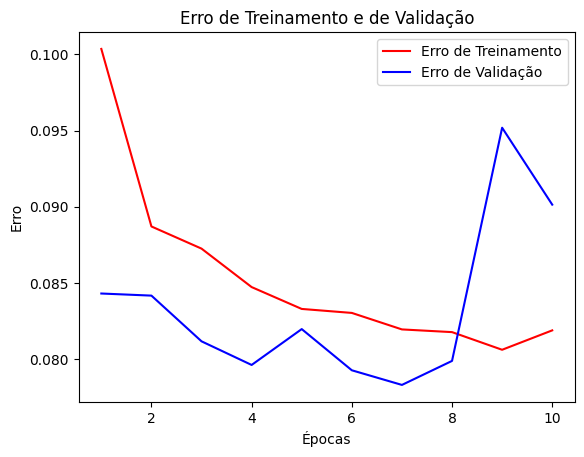

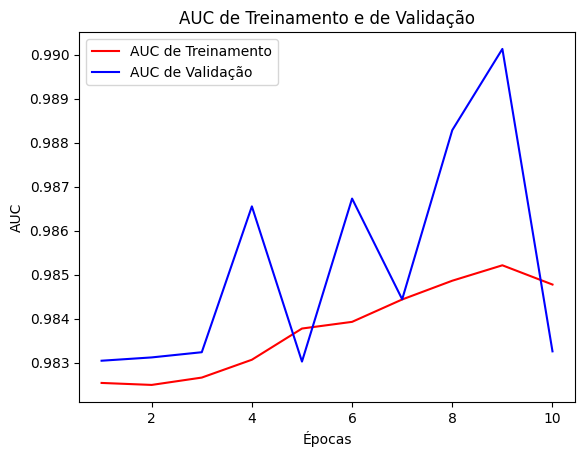

In [12]:
import matplotlib.pyplot as plt


train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
train_auc = model_history.history['auc']
val_auc = model_history.history['val_auc']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'r', label='Erro de Treinamento')
plt.plot(epochs, val_loss, 'b', label='Erro de Validação')
plt.title('Erro de Treinamento e de Validação')
plt.xlabel('Épocas')
plt.ylabel('Erro')
plt.legend()
plt.show()

plt.plot(epochs, train_auc, 'r', label='AUC de Treinamento')
plt.plot(epochs, val_auc, 'b', label='AUC de Validação')
plt.title('AUC de Treinamento e de Validação')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [ ]:
# Evaluation and Metrics
predictions = model.predict(validation_generator)
y_true = validation_generator.classes
y_pred = predictions.argmax(axis=1)


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

false_positive_rate = confusion_mat[0, 1] / (confusion_mat[0, 1] + confusion_mat[0, 0])
print("False Positive Rate:", false_positive_rate)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_true, y_pred)

# Create a figure and axis
fig, ax = plt.subplots()

# Create a heatmap using the confusion matrix
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False)

# Set labels, title, and ticks
ax.set_xlabel('Predito')
ax.set_ylabel('Verdadeiro')
ax.set_title('Matriz de Confusão para o Conjunto de Validação')

# Add tick labels
class_names = ['Benigno', 'Maligno']  # Replace with your actual class names
tick_marks = range(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Display the plot
plt.show()
